<a href="https://colab.research.google.com/github/mille055/stanford_project/blob/dockerversion/app/notebooks/Stanford_CS231N_0607b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
COLAB_FLAG = True   # whether running on colab or locally on computer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
if COLAB_FLAG:
  %pip install pydicom==2.1.2
  %pip install monai seaborn sentence_transformers
  !git clone -b dockerversion 'https://github.com/mille055/stanford_project.git'
  

    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 85.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 88.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 112.5 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=2455106bb2ec1c466fec42d6d5e97016a0eb69087975aee018c365f634b81d1e
  Stored in directory:

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from datetime import datetime

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from pprint import pprint
from fastai.basics import delegates
from fastcore.parallel import parallel
from fastcore.utils import gt
from fastcore.foundation import L

from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import importlib
import warnings
from google.colab import drive
warnings.filterwarnings("ignore")

from PIL import Image


In [5]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/stanford_project/app/scripts/')
    train_datafile = '/content/stanford_project/app/data/trainfiles.csv'
    val_datafile = '/content/stanford_project/app/data/valfiles.csv'
    test_datafile = '/content/stanford_project/app/data/testfiles.csv'
    
    drive.mount('/content/gdrive')

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/new/stanford_project/app/scripts/')
    #sys.path.append('/workspaces/stanford_project/app/scripts/')
    train_datafile = '../data/trainfiles.csv'
    val_datafile = '../data/valfiles.csv'
    test_datafile = '../data/testfiles.csv'


### local imports ###
from config import file_dict, feats, feats_to_keep, column_lists, RF_parameters, classes, model_paths
from config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from utils import *

from cnn.cnn_dataset import ImgDataset
from cnn.cnn_inference import image_to_tensor, pixel_inference, test_pix_model, load_pixel_model, visualize_results
from cnn.cnn_model import *
from cnn.cnn_training import *
from cnn.cnn_data_loaders import get_data_loaders, data_transforms, data_transforms2, data_transforms3, data_transforms4

from model_container import ModelContainer



Mounted at /content/gdrive


# Create Datasets and DataLoaders

In [ ]:

#create the datasets
#train_df, val_df, test_df = create_datasets(train_datafile, val_datafile, test_datafile, '/volumes/cm7/Abdominal_MRI_dataset_split/', '/content/gdrive/MyDrive/WW_MRI_abd2/split/' )



Creating an alternative dataframe where the val images are randomly chosen rather than the midpoint as originally performed. Also, creating a larger train dataset to explore. 

In [ ]:
# val_ran_df = create_dataset(val_datafile, '/volumes/cm7/Abdominal_MRI_dataset_split/', '/content/gdrive/MyDrive/WW_MRI_abd2/split/', selection_behavior = 'random', a=0.1, b=0.9)
# train_large_df = create_dataset(train_datafile, '/volumes/cm7/Abdominal_MRI_dataset_split/', '/content/gdrive/MyDrive/WW_MRI_abd2/split/', selection_behavior='range', a=0.1, b=0.9)

# val_ran_df.to_pickle('/content/gdrive/MyDrive/val_ran_df.pkl')
# train_large_df.to_pickle('/content_grdive/MyDrive/train_large_df.pkl')

In [ ]:
# val_ran_df
# val_ran_df.to_pickle('/content/gdrive/MyDrive/val_ran_df.pkl')

In [8]:
# have already pickled the datasets and just loading here
# midpoint datasets
train_df = pd.read_pickle('/content/gdrive/MyDrive/train_df.pkl')
val_df = pd.read_pickle('/content/gdrive/MyDrive/val_df.pkl')
test_df = pd.read_pickle('/content/gdrive/MyDrive/test_df.pkl')

# randomly chosen single image within each series
train_df_ran = pd.read_pickle('/content/gdrive/MyDrive/train_df_ran.pkl')
val_df_ran = pd.read_pickle('/content/gdrive/MyDrive/val_df_ran.pkl')
test_df_ran = pd.read_pickle('/content/gdrive/MyDrive/test_df_ran.pkl')

# single image chosen at 0.3 way between start and end for each series
train_df_03 = pd.read_pickle('/content/gdrive/MyDrive/train_df_03.pkl')
val_df_03 = pd.read_pickle('/content/gdrive/MyDrive/val_df_03.pkl')
test_df_03 = pd.read_pickle('/content/gdrive/MyDrive/test_df_03.pkl')


In [9]:
# Get the data loaders
# dataloaders - vanilla, no augmentation just cropping and resizing, number channels to 1, and to tensor
# dataloaders2 - some augmentation (color jitter)
# dataloaders3 - some augmentation (color jitter) as well as use of a gamma filter with parameter = 2 to highlight bright pixels
# dataloaders4 - some augmentation (color jitter) as well as use of a gamma filter with parameter = 0.5 for comparison

batch_size = 16
train_loader, val_loader, test_loader, dataset_sizes = get_data_loaders(train_df, val_df, test_df, batch_size)
train_loader2, val_loader2, test_loader2, dataset_sizes2 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms2)
train_loader3, val_loader3, test_loader3, dataset_sizes3 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms3)
train_loader4, val_loader4, test_loader4, dataset_sizes4 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms4)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataloaders2 = {'train': train_loader2, 'val': val_loader2, 'test': test_loader2}
dataloaders3 = {'train': train_loader3, 'val': val_loader3, 'test': test_loader3}
dataloaders4 = {'train': train_loader4, 'val': val_loader4, 'test': test_loader4}


# Explore Base Model Archictectures#

Comparing the accuracy of various models on the validation dataset. There are two variations of the ResNet50 model, the first (CustomResNet) with a single fully connected layer as the head and the second (CustomResNetb) with two fully connected layers separated by ReLU. There is also a DenseNet model with a single fully connected layer as the head. Both SGD and Adam optimizers are used for each combination, as are Cross Entropy Loss and a custom Focal Loss. 

For data preparation, there are four different combinations: a vanilla transformer that only uses cropping and resizing, transformer2 which also uses some augmentation (color jitter), and transformers 3 and 4 which use a gamma function to alter the image (presumably to highlight bright pixels) with two different settings for comparison (although will likely perform the last comparison only on the 'best model' from the other comparisons. 

In [12]:
# Different combinations to evaluate
models = [CustomDenseNet]
loss_funcs = [FocalLoss, nn.CrossEntropyLoss] 
loaders = ['dataloaders2']
loaders_dict = {'dataloaders': dataloaders, 'dataloaders2': dataloaders2, 'dataloaders3': dataloaders3, 'dataloaders4': dataloaders4}
optimizers = ['Adam']
optim_dict = {

    'SGD': {
        'class': torch.optim.SGD,
        'params': {'lr': 0.001, 'momentum': 0.9}
    },
    'Adam': {
        'class': torch.optim.Adam,
        'params': {'lr': 0.001, 'betas': (0.9, 0.999)}
    }
}



Training with CustomDenseNet, dataloaders2, Adam, FocalLoss


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 77.0MB/s]


Epoch 0/14
----------
train Loss: 1.0851 Acc: 0.5259
val Loss: 1.4205 Acc: 0.5000

Epoch 1/14
----------
train Loss: 0.6177 Acc: 0.6757
val Loss: 0.7051 Acc: 0.6723

Epoch 2/14
----------
train Loss: 0.4447 Acc: 0.7516
val Loss: 0.5922 Acc: 0.7232

Epoch 3/14
----------
train Loss: 0.3283 Acc: 0.7962
val Loss: 0.5702 Acc: 0.7006

Epoch 4/14
----------
train Loss: 0.3038 Acc: 0.8137
val Loss: 0.6708 Acc: 0.6949

Epoch 5/14
----------
train Loss: 0.2694 Acc: 0.8283
val Loss: 0.6885 Acc: 0.6864

Epoch 6/14
----------
train Loss: 0.1629 Acc: 0.8824
val Loss: 0.5244 Acc: 0.7825

Epoch 7/14
----------
train Loss: 0.0815 Acc: 0.9430
val Loss: 0.2930 Acc: 0.8277

Epoch 8/14
----------
train Loss: 0.0498 Acc: 0.9591
val Loss: 0.2863 Acc: 0.8446

Epoch 9/14
----------
train Loss: 0.0475 Acc: 0.9671
val Loss: 0.2899 Acc: 0.8559

Epoch 10/14
----------
train Loss: 0.0348 Acc: 0.9737
val Loss: 0.2753 Acc: 0.8672

Epoch 11/14
----------
train Loss: 0.0274 Acc: 0.9810
val Loss: 0.2461 Acc: 0.8757

Ep

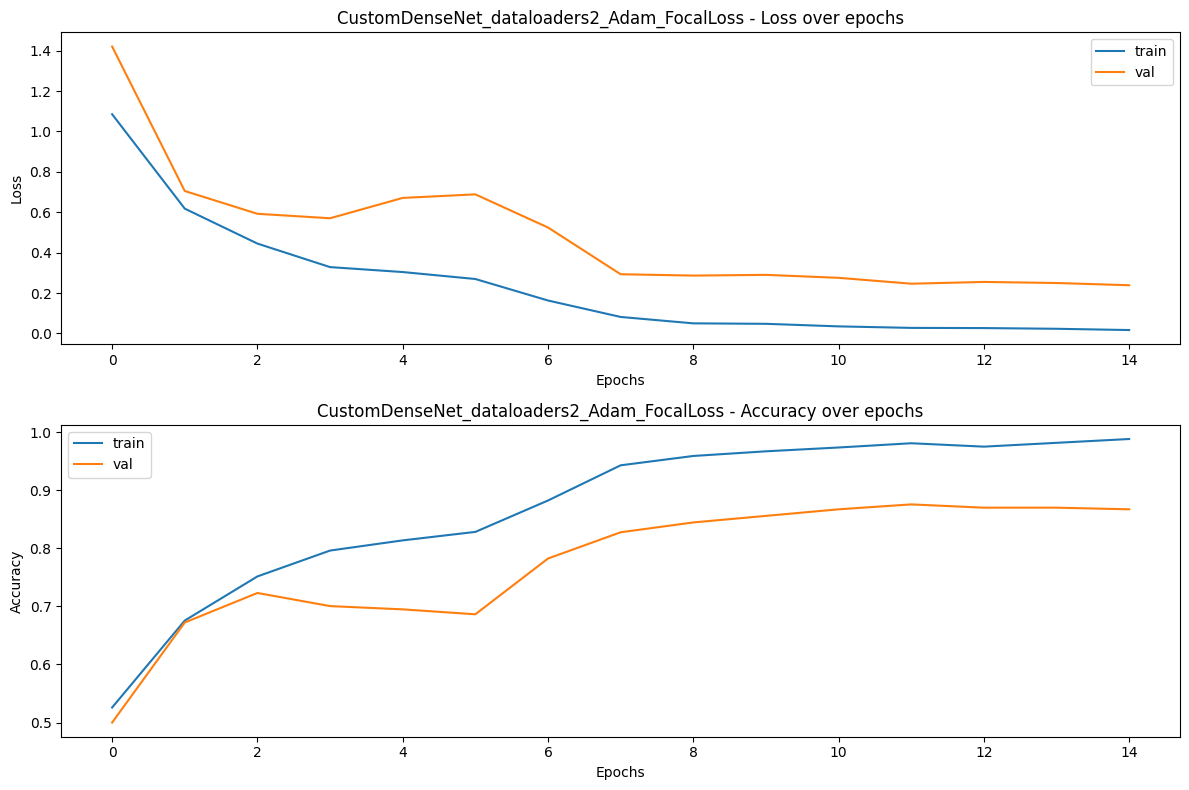


Training with CustomDenseNet, dataloaders2, Adam, CrossEntropyLoss
Epoch 0/14
----------
train Loss: 1.3892 Acc: 0.5720
val Loss: 1.6136 Acc: 0.5000

Epoch 1/14
----------
train Loss: 0.8524 Acc: 0.7429
val Loss: 1.2876 Acc: 0.5819

Epoch 2/14
----------
train Loss: 0.7032 Acc: 0.7772
val Loss: 0.9454 Acc: 0.6836

Epoch 3/14
----------
train Loss: 0.5568 Acc: 0.8115
val Loss: 1.2416 Acc: 0.6412

Epoch 4/14
----------
train Loss: 0.4943 Acc: 0.8327
val Loss: 0.7933 Acc: 0.7345

Epoch 5/14
----------
train Loss: 0.4147 Acc: 0.8576
val Loss: 0.7615 Acc: 0.7542

Epoch 6/14
----------
train Loss: 0.3627 Acc: 0.8839
val Loss: 0.6554 Acc: 0.7881

Epoch 7/14
----------
train Loss: 0.1714 Acc: 0.9503
val Loss: 0.4745 Acc: 0.8475

Epoch 8/14
----------
train Loss: 0.1234 Acc: 0.9671
val Loss: 0.4877 Acc: 0.8475

Epoch 9/14
----------
train Loss: 0.1001 Acc: 0.9737
val Loss: 0.4566 Acc: 0.8588

Epoch 10/14
----------
train Loss: 0.0856 Acc: 0.9817
val Loss: 0.4523 Acc: 0.8588

Epoch 11/14
------

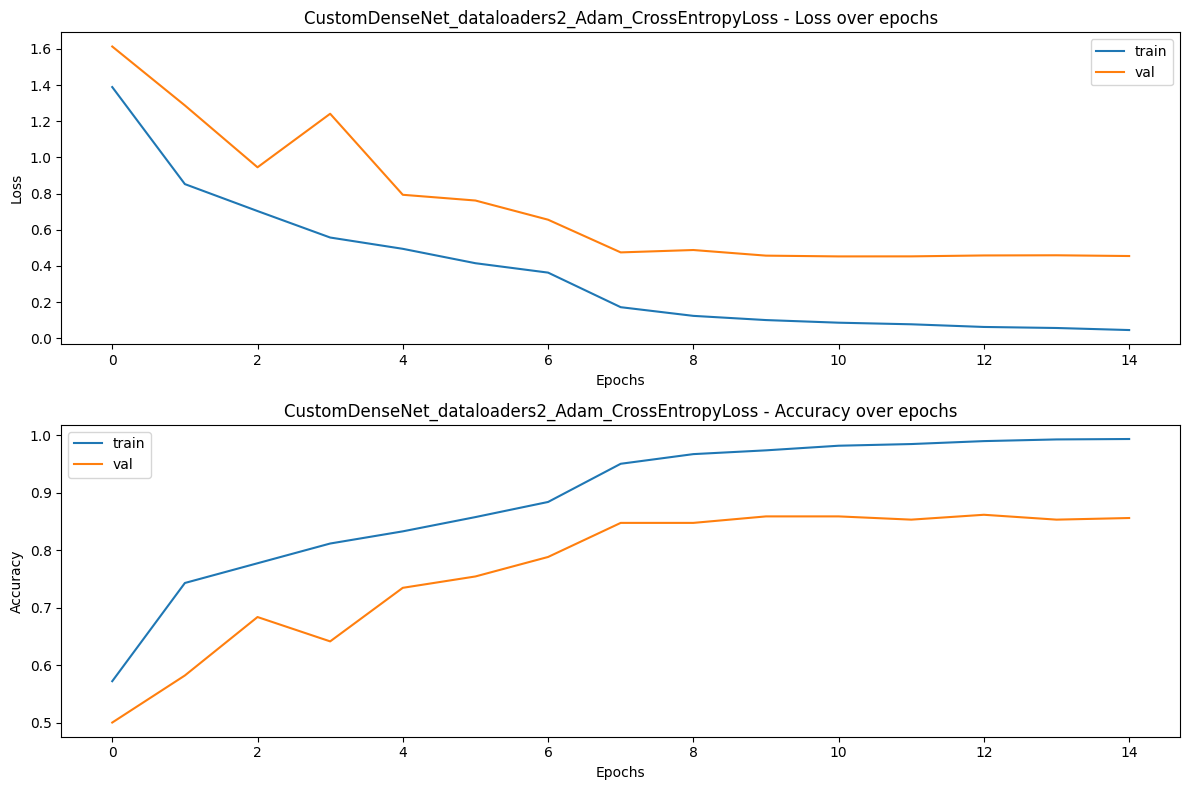

In [13]:
# perform several training runs to compare accuracy on the validation dataset
best_model = None
best_accuracy = -1

for model_class in models:
  for loader in loaders:
        for opt in optimizers:
            for loss_func_class in loss_funcs:
                print(f"\nTraining with {model_class.__name__}, {loader}, {opt}, {loss_func_class.__name__}")

                # Instantiate the custom model
                num_classes = len(classes)
                model = model_class(num_classes)
                model = model.to(device)  # Move the model to the appropriate device

                # Define loss function 
                criterion = loss_func_class()
               
                # Instantiate the selected optimizer with its parameters
                opt_class = optim_dict[opt]['class']
                opt_params = optim_dict[opt]['params']
                optimizer = opt_class(model.parameters(), **opt_params)
               
                #optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)

                # Decay LR by a factor of 0.1 every 7 epochs
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

                # Select the dataloader
                dataloaders = loaders_dict[loader]

                # Train the model
                trained_model, best_val_accuracy, history = train_cnn_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

                # Print the history data
                print("Training loss history:", history['train_loss'])
                print("Validation loss history:", history['val_loss'])
                print("Training accuracy history:", history['train_acc'])
                print("Validation accuracy history:", history['val_acc'])


                # Plot training curves
                combination_name = f"{model_class.__name__}_{loader}_{opt}_{loss_func_class.__name__}"
                plot_training_curves(history, combination_name)

                if best_val_accuracy > best_accuracy:
                  best_model = trained_model
                  best_combo = combination_name
                  best_accuracy = best_val_accuracy
               

In [14]:
def display_and_save_results2(y_pred, y_true, classes=classes, fn='', saveflag = True):
   

    classes_raw_list = np.unique(np.concatenate((y_true, y_pred)))
    print(classes_raw_list)
    classes_list = [classes[x] for x in classes_raw_list]
    print(classes_list)
    y_true = [classes[x] for x in y_true]
    y_pred = [classes[x] for x in y_pred]
    # Generate a confusion matrix based on the true labels and predicted labels
    cm = confusion_matrix(y_true = y_true, y_pred = y_pred, labels=classes_list)
  
    #mask = np.all(cm == 0, axis=1)

    class_text_labels = np.array([abd_label_dict[str(x)]['short'] for x in classes_list])
    #class_text_labels = class_text_labels[~mask]

     # Generate a classification report based on the true labels and predicted labels
    print(classification_report(y_true, y_pred))

    
    #cm = cm[~mask]
    # Create a ConfusionMatrixDisplay object with the correct labels
    cm_display = ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    plt.figure(figsize=(25, 25))
    plt.tight_layout()
    #ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    if saveflag:
        plt.savefig("/content/FigCM_"+fn+datetime.today().strftime('%Y%m%d')+".tif",dpi=300, bbox_inches = 'tight')     

    return cm      



[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 17 18]
[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           2       0.91      0.84      0.87        49
           6       0.88      1.00      0.93        14
           7       0.94      0.94      0.94        18
           8       0.89      0.97      0.93        35
           9       0.97      0.94      0.96        34
          11       1.00      0.90      0.95        20
          12       0.50      0.17      0.25        12
          13       1.00      0.33      0.50         3
          14       1.00      1.00      1.00        19
          16       0.56      0.75      0.64        20
          17       0.94      0.94      0.94        17
          18       1.00      0.95      0.98        22
          19       1.00      0.95      0.97        19
          23       0.56      0.53      0.54        19
          25       0.80   

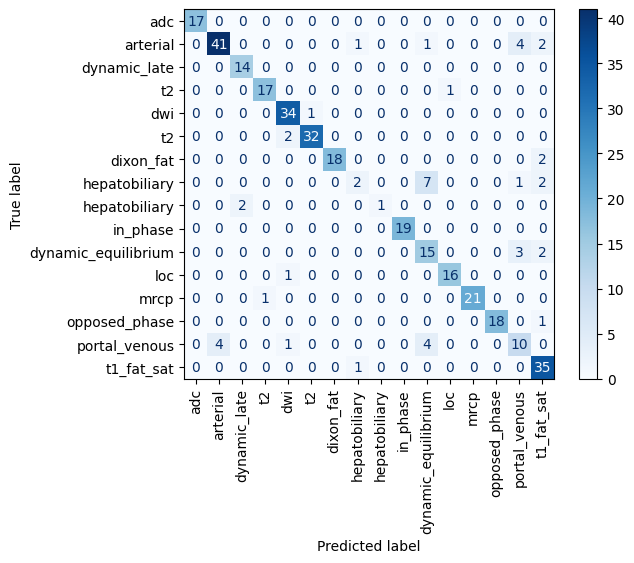

<Figure size 2500x2500 with 0 Axes>

In [15]:
# Evaluate the model on the val dataset
model = best_model

model.eval()
val_predictions = []
val_labels = []

for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        val_predictions.append(predicted.cpu().numpy())
        val_labels.append(labels.cpu().numpy())
val_predictions = np.concatenate(val_predictions, axis=0)
val_labels = np.concatenate(val_labels, axis=0)


save_filename = f"cnn_model_{best_combo}_{datetime.now().strftime('%Y%m%d')}.pth"

cm = display_and_save_results2(val_predictions, val_labels, classes, fn=save_filename, saveflag=True)

# Save the trained model if needed

torch.save(trained_model.state_dict(), f'/content/gdrive/MyDrive/{save_filename}')




In [19]:
torch.save(trained_model.state_dict(), f'/content/gdrive/MyDrive/best_0606.pth')


[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 17 18]
[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        17
           2       0.98      0.86      0.91        49
           6       0.88      1.00      0.93        14
           7       0.94      0.94      0.94        18
           8       0.94      0.91      0.93        35
           9       0.94      0.97      0.96        34
          11       1.00      0.90      0.95        20
          12       0.00      0.00      0.00        12
          13       1.00      0.33      0.50         3
          14       0.90      0.95      0.92        19
          16       0.42      0.70      0.53        20
          17       1.00      0.94      0.97        17
          18       0.95      0.95      0.95        22
          19       1.00      0.95      0.97        19
          23       0.64      0.47      0.55        19
          25       0.78   

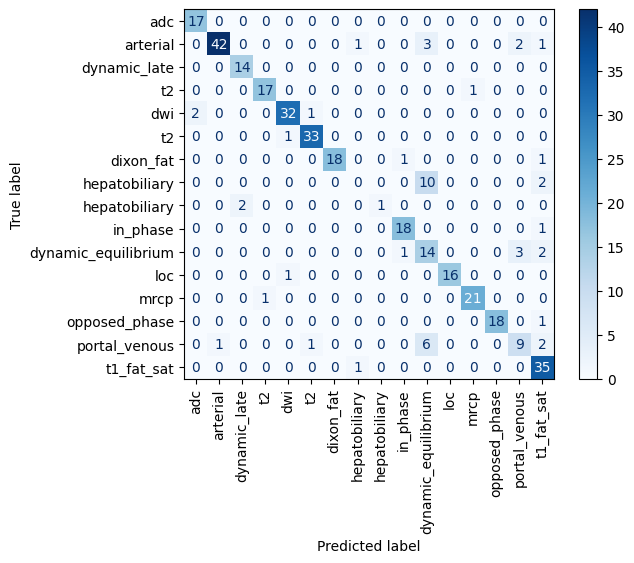

<Figure size 2500x2500 with 0 Axes>

In [21]:
# Evaluate the previously saved best model on the val dataset
loaded_model = CustomDenseNet()

# Load the saved model
state_dict = torch.load('/content/gdrive/MyDrive/best_0606.pth')

# Load the state dictionary into the model
loaded_model.load_state_dict(state_dict)


# Evaluate the model on the test dataset
model = loaded_model.to(device)
model.eval()
val_predictions = []
val_labels = []

for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        val_predictions.append(predicted.cpu().numpy())
        val_labels.append(labels.cpu().numpy())
val_predictions = np.concatenate(val_predictions, axis=0)
val_labels = np.concatenate(val_labels, axis=0)


save_filename = f"cnn_model_{best_combo}_{datetime.now().strftime('%Y%m%d')}.pth"

cm = display_and_save_results2(val_predictions, val_labels, classes, fn=save_filename, saveflag=True)

# Save the trained model if needed




#Experiment: gamma filter with different hyperparameter#
Looking at applying a gamma filter on the images with two different settings to see if it affects accuracy. One of the key components that a human looks at is the distribution of bright pixels (and how they correspond to different portions of anatomy), so a gamma filter may affect how bright pixels are accentuated in the image. 


Training with CustomDenseNet, dataloaders3, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.0042 Acc: 0.5668
val Loss: 1.8829 Acc: 0.4972

Epoch 1/14
----------
train Loss: 0.6055 Acc: 0.6903
val Loss: 2.3227 Acc: 0.3927

Epoch 2/14
----------
train Loss: 0.4486 Acc: 0.7480
val Loss: 0.6272 Acc: 0.6864

Epoch 3/14
----------
train Loss: 0.3808 Acc: 0.7904
val Loss: 0.6343 Acc: 0.6977

Epoch 4/14
----------
train Loss: 0.3251 Acc: 0.8057
val Loss: 0.4313 Acc: 0.7853

Epoch 5/14
----------
train Loss: 0.2526 Acc: 0.8400
val Loss: 0.5363 Acc: 0.7288

Epoch 6/14
----------
train Loss: 0.2329 Acc: 0.8495
val Loss: 0.5624 Acc: 0.7401

Epoch 7/14
----------
train Loss: 0.1203 Acc: 0.9204
val Loss: 0.3374 Acc: 0.8333

Epoch 8/14
----------
train Loss: 0.0614 Acc: 0.9562
val Loss: 0.3116 Acc: 0.8305

Epoch 9/14
----------
train Loss: 0.0442 Acc: 0.9620
val Loss: 0.2764 Acc: 0.8305

Epoch 10/14
----------
train Loss: 0.0358 Acc: 0.9759
val Loss: 0.2963 Acc: 0.8305

Epoch 11/14
----------
tr

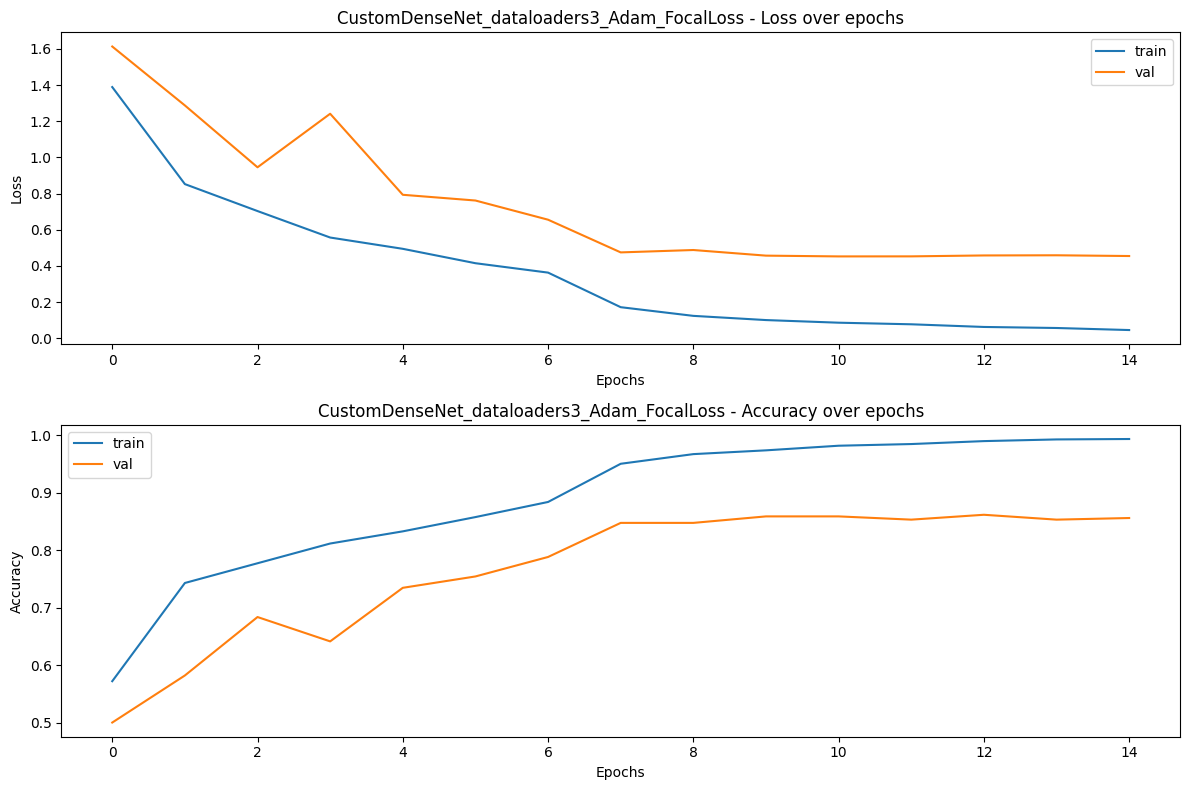


Training with CustomDenseNet, dataloaders4, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.0123 Acc: 0.5603
val Loss: 0.7814 Acc: 0.6356

Epoch 1/14
----------
train Loss: 0.5486 Acc: 0.7173
val Loss: 1.0695 Acc: 0.6384

Epoch 2/14
----------
train Loss: 0.4600 Acc: 0.7531
val Loss: 0.9362 Acc: 0.6328

Epoch 3/14
----------
train Loss: 0.3798 Acc: 0.7728
val Loss: 0.5857 Acc: 0.7175

Epoch 4/14
----------
train Loss: 0.3493 Acc: 0.7955
val Loss: 1.1056 Acc: 0.5847

Epoch 5/14
----------
train Loss: 0.2400 Acc: 0.8408
val Loss: 0.7279 Acc: 0.6723

Epoch 6/14
----------
train Loss: 0.1772 Acc: 0.8656
val Loss: 0.4558 Acc: 0.7655

Epoch 7/14
----------
train Loss: 0.1073 Acc: 0.9270
val Loss: 0.2825 Acc: 0.8531

Epoch 8/14
----------
train Loss: 0.0627 Acc: 0.9503
val Loss: 0.2835 Acc: 0.8418

Epoch 9/14
----------
train Loss: 0.0428 Acc: 0.9664
val Loss: 0.2781 Acc: 0.8559

Epoch 10/14
----------
train Loss: 0.0352 Acc: 0.9774
val Loss: 0.2734 Acc: 0.8503

Epoch 11/14
----------
tr

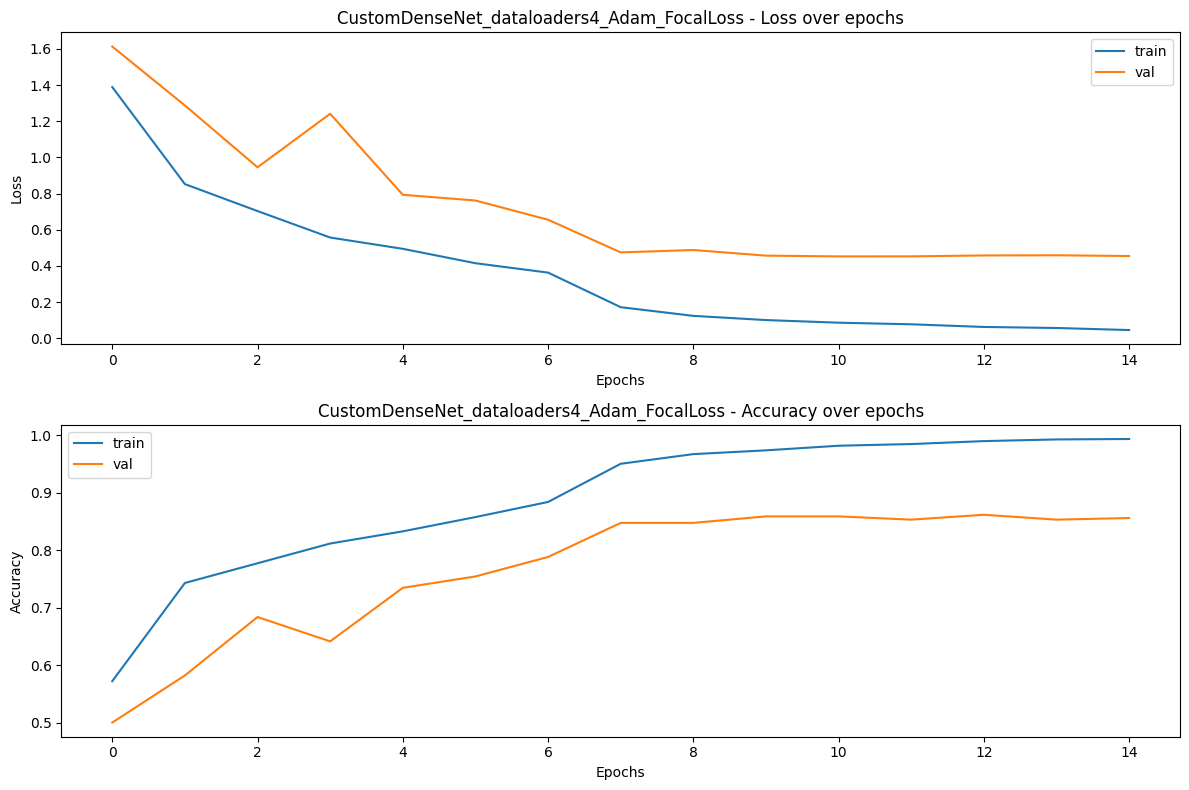

In [22]:
# perform several training runs to compare accuracy on the validation dataset


models_g = [CustomDenseNet]
loss_funcs_g = [FocalLoss] 
loaders_g = ['dataloaders3', 'dataloaders4']
optimizers_g = ['Adam']

best_model_g = None
best_accuracy_g = -1

for model_class in models_g:
  for loader in loaders_g:
        for opt in optimizers_g:
            for loss_func_class in loss_funcs_g:
                print(f"\nTraining with {model_class.__name__}, {loader}, {opt}, {loss_func_class.__name__}")

                # Instantiate the custom model
                num_classes = len(classes)
                model = model_class(num_classes)
                model = model.to(device)  # Move the model to the appropriate device

                # Define loss function 
                criterion = loss_func_class()
               
                # Instantiate the selected optimizer with its parameters
                opt_class = optim_dict[opt]['class']
                opt_params = optim_dict[opt]['params']
                optimizer = opt_class(model.parameters(), **opt_params)
               
                #optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)

                # Decay LR by a factor of 0.1 every 7 epochs
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

                # Select the dataloader
                dataloaders = loaders_dict[loader]

                # Train the model
                trained_model_g, best_val_accuracy_g, history_g = train_cnn_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

                # Print the history data
                print("Training loss history:", history_g['train_loss'])
                print("Validation loss history:", history_g['val_loss'])
                print("Training accuracy history:", history_g['train_acc'])
                print("Validation accuracy history:", history_g['val_acc'])


                # Plot training curves
                combination_name_g = f"{model_class.__name__}_{loader}_{opt}_{loss_func_class.__name__}"
                plot_training_curves(history, combination_name_g)

                if best_val_accuracy_g > best_accuracy_g:
                  best_model_g = trained_model_g
                  best_combo_g = combination_name_g
                  best_accuracy_g = best_val_accuracy_g
               


#Experiment: Same slice versus different random slice on inference#
Comparing the results with the validation dataset using the same 'center slice' method as for the training data, versus using a random image from each series as the alternative validation dataset. 

In [24]:
# Create an instance of the model class
loaded_model = CustomDenseNet()


# Load the saved model
state_dict = torch.load('/content/gdrive/MyDrive/best_0606.pth')


# Load the state dictionary into the model
loaded_model.load_state_dict(state_dict)


# Evaluate the model on the test dataset
model = loaded_model.to(device)

[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 17 18]
[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        17
           2       0.69      0.63      0.66        49
           6       0.69      0.64      0.67        14
           7       0.86      0.67      0.75        18
           8       0.89      0.89      0.89        35
           9       0.91      0.91      0.91        34
          11       0.64      0.80      0.71        20
          12       0.25      0.17      0.20        12
          13       0.00      0.00      0.00         3
          14       0.70      0.84      0.76        19
          16       0.55      0.60      0.57        20
          17       0.57      0.71      0.63        17
          18       0.91      0.95      0.93        22
          19       0.85      0.58      0.69        19
          23       0.46      0.32      0.37        19
          25       0.65   

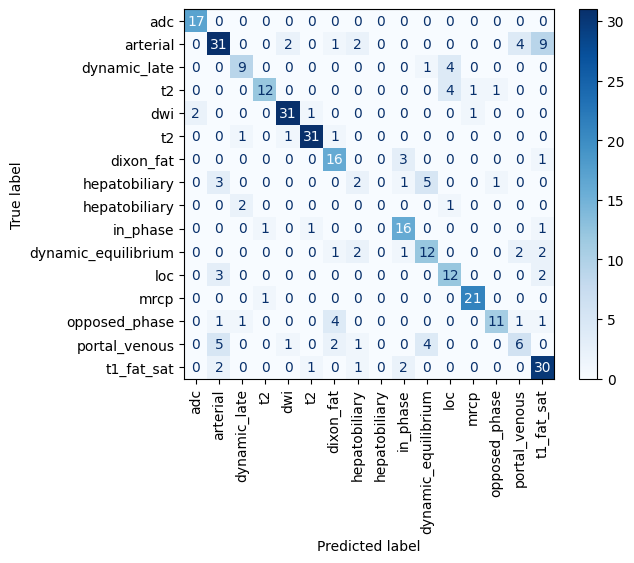

<Figure size 2500x2500 with 0 Axes>

In [25]:
# Evaluate the model on the random val dataset


model.eval()
val_ran_predictions = []
val_ran_labels = []
train_ran_loader, val_ran_loader, test_ran_loader, _ = get_data_loaders(train_df_ran, val_df_ran, test_df_ran, batch_size, data_transforms=data_transforms2)

for inputs, labels in val_ran_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        val_ran_predictions.append(predicted.cpu().numpy())
        val_ran_labels.append(labels.cpu().numpy())
val_ran_predictions = np.concatenate(val_ran_predictions, axis=0)
val_ran_labels = np.concatenate(val_ran_labels, axis=0)


#save_filename = f"cnn_model_randomval_{best_combo}_{datetime.now().strftime('%Y%m%d')}.pth"

cm = display_and_save_results2(val_ran_predictions, val_ran_labels, classes, fn=save_filename, saveflag=True)




Much lower accuracy when the validation images are randomly selected but the train images are all the midpoint images. Will have to see if training over random train images or the full set of train images will help this. In the meantime, for any inference would select the midpoint images to match what the model was trained on. 


Training with CustomDenseNet, dataloaders_03, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.0184 Acc: 0.5537
val Loss: 1.8774 Acc: 0.3305

Epoch 1/14
----------
train Loss: 0.6634 Acc: 0.6691
val Loss: 0.9528 Acc: 0.6045

Epoch 2/14
----------
train Loss: 0.4579 Acc: 0.7356
val Loss: 0.5874 Acc: 0.6864

Epoch 3/14
----------
train Loss: 0.3714 Acc: 0.7816
val Loss: 0.6180 Acc: 0.6610

Epoch 4/14
----------
train Loss: 0.3053 Acc: 0.8159
val Loss: 0.6353 Acc: 0.7288

Epoch 5/14
----------
train Loss: 0.2676 Acc: 0.8291
val Loss: 0.5045 Acc: 0.7486

Epoch 6/14
----------
train Loss: 0.2235 Acc: 0.8444
val Loss: 1.0826 Acc: 0.6102

Epoch 7/14
----------
train Loss: 0.1230 Acc: 0.9028
val Loss: 0.3863 Acc: 0.7966

Epoch 8/14
----------
train Loss: 0.0590 Acc: 0.9569
val Loss: 0.3661 Acc: 0.8136

Epoch 9/14
----------
train Loss: 0.0511 Acc: 0.9591
val Loss: 0.3689 Acc: 0.8136

Epoch 10/14
----------
train Loss: 0.0393 Acc: 0.9671
val Loss: 0.3666 Acc: 0.8136

Epoch 11/14
----------


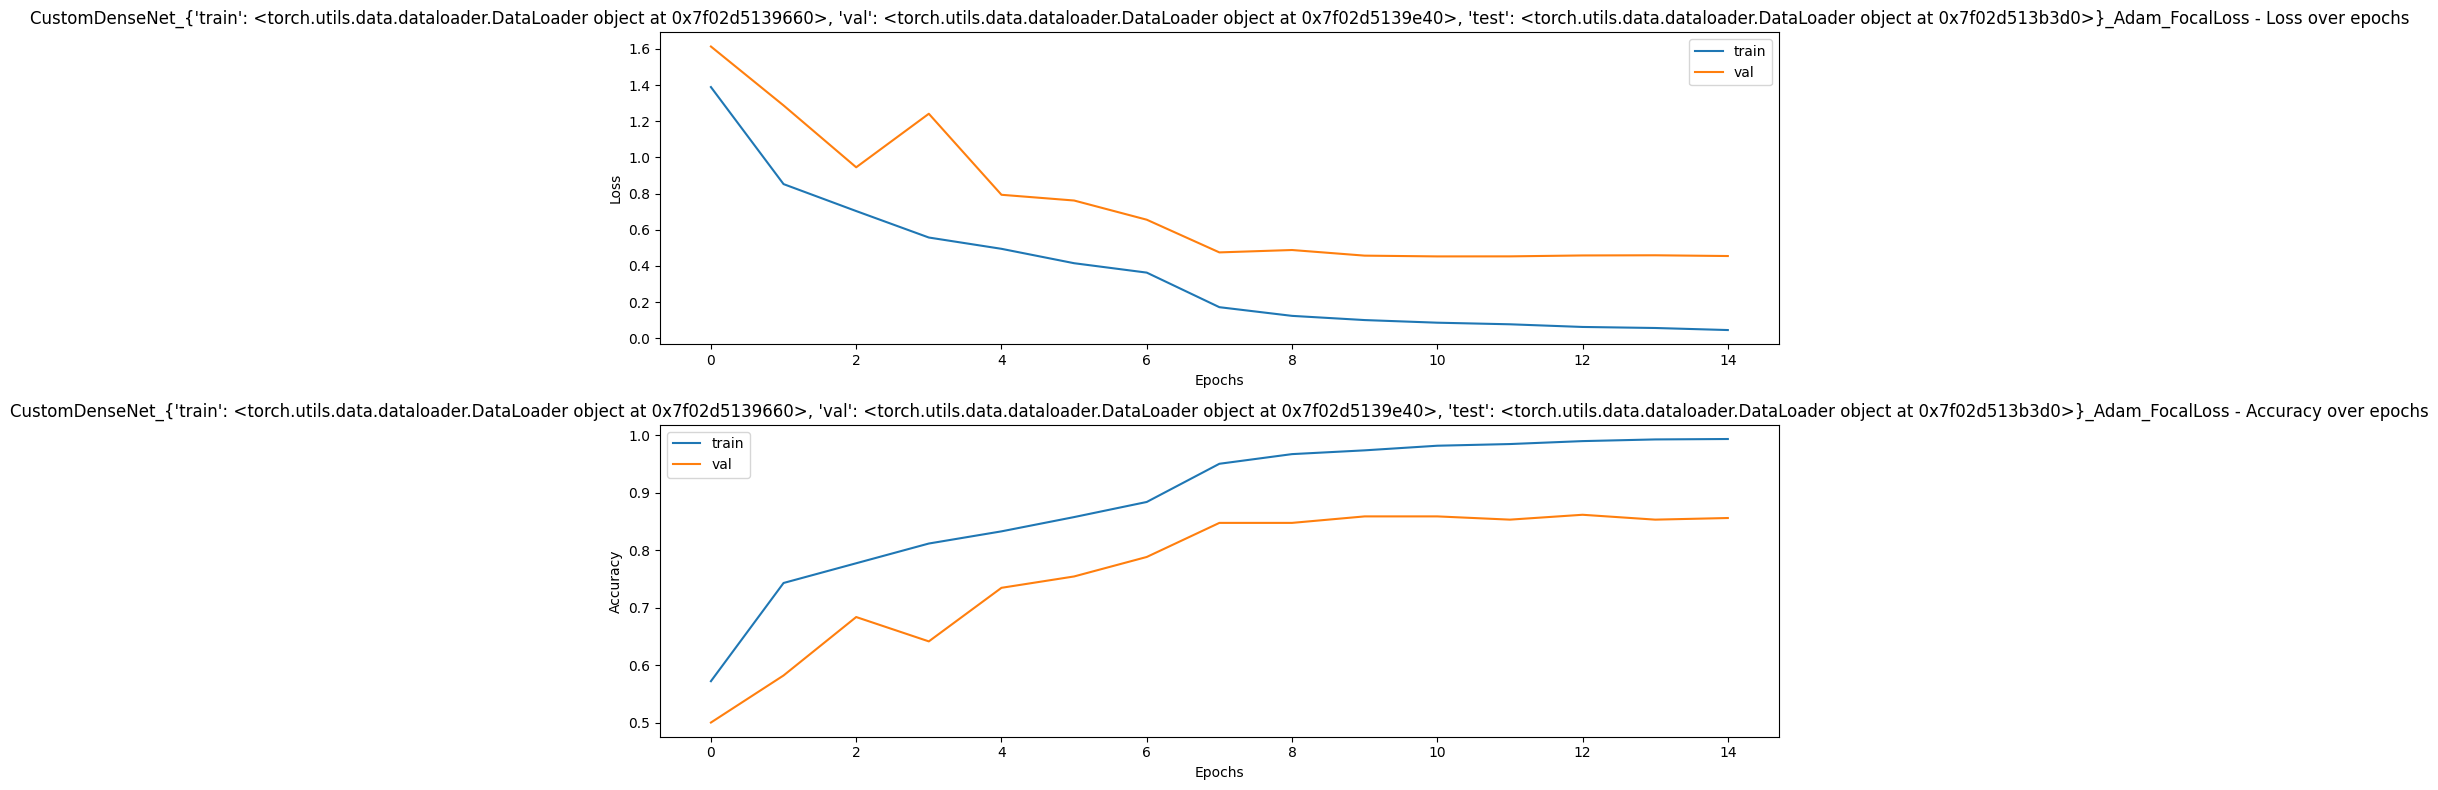


Training with CustomDenseNet, dataloaders_ran, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.1971 Acc: 0.4872
val Loss: 1.5916 Acc: 0.4774

Epoch 1/14
----------
train Loss: 0.7915 Acc: 0.6377
val Loss: 1.1983 Acc: 0.5169

Epoch 2/14
----------
train Loss: 0.6475 Acc: 0.6735
val Loss: 0.9238 Acc: 0.5989

Epoch 3/14
----------
train Loss: 0.5186 Acc: 0.7217
val Loss: 0.7974 Acc: 0.6723

Epoch 4/14
----------
train Loss: 0.3662 Acc: 0.8020
val Loss: 0.7889 Acc: 0.6554

Epoch 5/14
----------
train Loss: 0.3482 Acc: 0.7925
val Loss: 1.6208 Acc: 0.5452

Epoch 6/14
----------
train Loss: 0.4058 Acc: 0.7626
val Loss: 0.8498 Acc: 0.6384

Epoch 7/14
----------
train Loss: 0.1803 Acc: 0.8839
val Loss: 0.5110 Acc: 0.7571

Epoch 8/14
----------
train Loss: 0.1134 Acc: 0.9291
val Loss: 0.4781 Acc: 0.7599

Epoch 9/14
----------
train Loss: 0.0906 Acc: 0.9401
val Loss: 0.4546 Acc: 0.7768

Epoch 10/14
----------
train Loss: 0.0774 Acc: 0.9467
val Loss: 0.4414 Acc: 0.7740

Epoch 11/14
----------

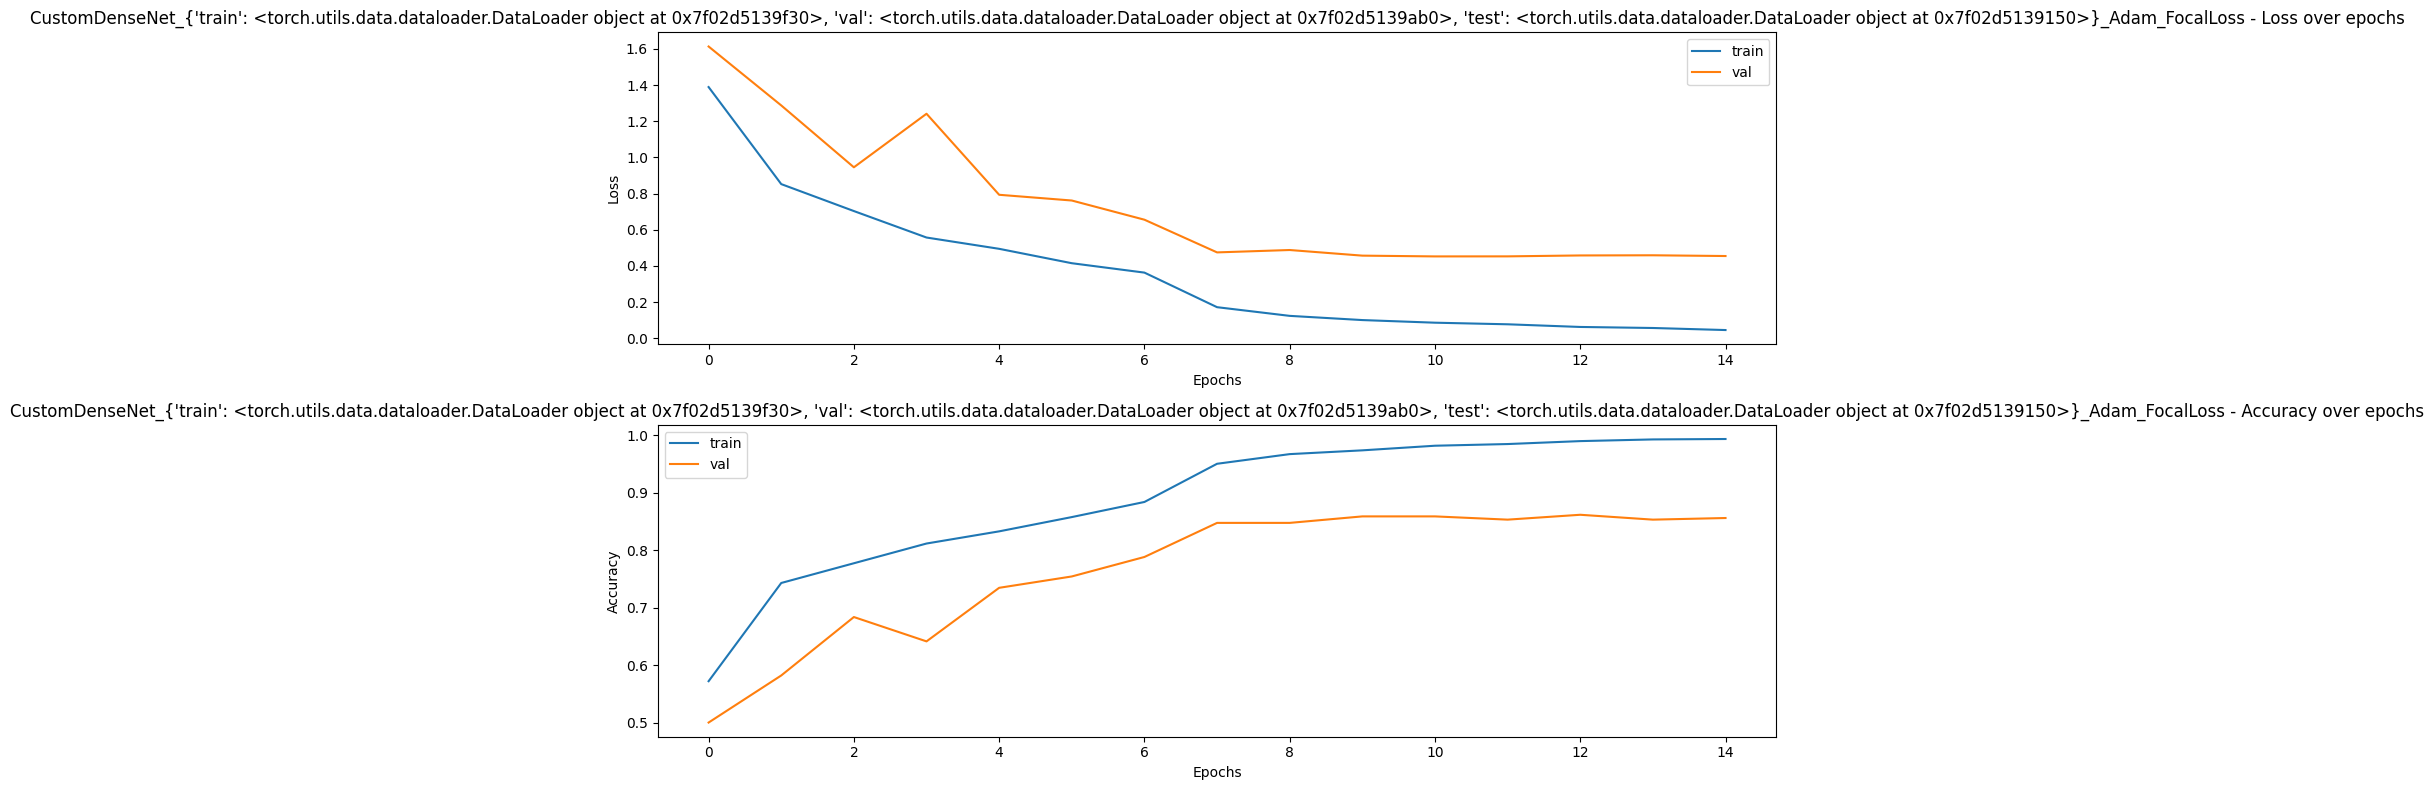

In [34]:
# Checking the performance if train on 0.03 and assess on validation 0.3 rather tha mnidpoint, as well as if both are chosen randomly
# Different combinations to evaluate

batch_size = 16
train_loader_03, val_loader_03, test_loader_03, dataset_sizes_03 = get_data_loaders(train_df_03, val_df_03, test_df_03, batch_size, data_transforms=data_transforms2)
dataloaders_03 = {'train': train_loader_03, 'val': val_loader_03, 'test': test_loader_03}


train_loader_ran, val_loader_ran, test_loader_ran, dataset_sizes_ran = get_data_loaders(train_df_ran, val_df_ran, test_df_ran, batch_size, data_transforms=data_transforms2)
dataloaders_ran = {'train': train_loader_ran, 'val': val_loader_ran, 'test': test_loader_ran}



models = [CustomDenseNet]
loss_funcs = [FocalLoss] 
loaders_exp = [dataloaders_03, dataloaders_ran]
loaders_dict_exp = {'dataloaders_03': dataloaders_03, 'dataloaders_ran': dataloaders_ran}
optims = ['Adam']

best_model_exp = None
best_accuracy_exp = -1

for model_class in models:
  for (loader_name, loader) in loaders_dict_exp.items():
        for opt in optims:
            for loss_func_class in loss_funcs:
                print(f"\nTraining with {model_class.__name__}, {loader_name}, {opt}, {loss_func_class.__name__}")

                # Instantiate the custom model
                num_classes = len(classes)
                model = model_class(num_classes)
                model = model.to(device)  # Move the model to the appropriate device

                # Define loss function 
                criterion = loss_func_class()
               
                # Instantiate the selected optimizer with its parameters
                opt_class = optim_dict[opt]['class']
                opt_params = optim_dict[opt]['params']
                optimizer = opt_class(model.parameters(), **opt_params)
               
                #optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)

                # Decay LR by a factor of 0.1 every 7 epochs
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

                # Train the model
                trained_model_exp, best_val_accuracy_exp, history_exp = train_cnn_model(model, loader, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

                # Print the history data
                print("Training loss history:", history_g['train_loss'])
                print("Validation loss history:", history_g['val_loss'])
                print("Training accuracy history:", history_g['train_acc'])
                print("Validation accuracy history:", history_g['val_acc'])


                # Plot training curves
                combination_name_exp = f"{model_class.__name__}_{loader}_{opt}_{loss_func_class.__name__}"
                plot_training_curves(history, combination_name_exp)

                if best_val_accuracy_exp > best_accuracy_exp:
                  best_model_exp = trained_model_exp
                  best_combo_exp = combination_name_exp
                  best_accuracy_exp = best_val_accuracy_exp
               


#Experiment: Focal Loss with different alpha values for each class# 
Introducing a new custom loss function (FocalLoss2) which accepts a dictionary of values for the alpha to specify the degree of emphasis for each class. This may negatively impact the overall accuracy, however. 

In [ ]:
import torch.nn.functional as F

class FocalLoss2(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss2, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')

        if self.alpha is not None:
            alpha_weights = torch.ones_like(CE_loss)
            alpha_weights *= self.alpha  # Initialize weights with alpha for all classes

            for cls, weight in self.alpha.items():
                alpha_weights[targets == cls] = weight  # Update weights for specified classes

            CE_loss *= alpha_weights

        pt = torch.exp(-CE_loss)
        F_loss = (1 - pt) ** self.gamma * CE_loss

        if self.reduction is None:
            return F_loss
        else:
            return torch.mean(F_loss)



class FocalLoss3(nn.Module):
    def __init__(self, alpha_list, gamma=2, reduction='mean'):
        super(FocalLoss3, self).__init__()
        self.alpha_list = torch.tensor(list(alpha_list.values()), dtype=torch.float32)  # Convert values to a list
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        device = inputs.device 
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        alpha_weights = self.alpha_list[targets.to(device)].to(device)
        focal_loss = (alpha_weights * (1 - pt) ** self.gamma * ce_loss).mean()

        return focal_loss


In [ ]:
alpha_list = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 2, 12: 2, 13: 1, 14: 1, 15: 1, 16: 1, 17: 2, 18: 1}
f_loss_fn = FocalLoss3(alpha_list = alpha_list, gamma=2)


In [ ]:
device

device(type='cuda')

In [ ]:
train_f_loader, val_f_loader, test_f_loader, size = get_data_loaders(train_df, val_df, test_df, batch_size=8, data_transforms=data_transforms2)
dataloaders_f = {'train': train_f_loader, 'val': val_f_loader, 'test': test_f_loader}

In [ ]:
# perform focal loss experiment on the validation dataset
# Evaluate the model on the test dataset
#model = loaded_model.to(device)
models = [CustomDenseNet]
loaders = ['dataloaders2']
optimizers = ['Adam']
loss_funcs = [f_loss_fn, FocalLoss]

best_model = None
best_accuracy = -1

for model_class in models:
  for loader in loaders:
        for opt in optimizers:
            for loss_func_class in loss_funcs:
                print(f"\nTraining with {model_class}, {loader}, {opt}, {loss_func_class}")

                # Instantiate the custom model
                num_classes = len(classes)
                model = model_class(num_classes)
                model = model.to(device)  # Move the model to the appropriate device

                # Instantiate the selected loss function
                criterion = loss_func_class

                
               
                # Instantiate the selected optimizer with its parameters
                opt_class = optim_dict[opt]['class']
                opt_params = optim_dict[opt]['params']
                optimizer = opt_class(model.parameters(), **opt_params)
               
                #optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)

                # Decay LR by a factor of 0.1 every 7 epochs
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

                # Select the dataloader
                dataloaders = loaders_dict[loader]

                # Train the model
                trained_model, best_val_accuracy, history = train_cnn_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

                # Print the history data
                print("Training loss history:", history['train_loss'])
                print("Validation loss history:", history['val_loss'])
                print("Training accuracy history:", history['train_acc'])
                print("Validation accuracy history:", history['val_acc'])


                # Plot training curves
                combination_name = f"{model_class.__name__}_{loader}_{opt}_{loss_func_class.__name__}"
                plot_training_curves(history, combination_name)

                if best_val_accuracy > best_accuracy:
                  best_model = trained_model
                  best_combo = combination_name
                  best_accuracy = best_val_accuracy
               


Training with <class 'cnn.cnn_model.CustomDenseNet'>, dataloaders2, Adam, FocalLoss3()
Epoch 0/14
----------


OutOfMemoryError: ignored

# Attempt at using Vision Transformers#

In [83]:
!pip install transformers
from transformers import DeiTFeatureExtractor, DeiTForImageClassification



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [84]:
deit_model = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
feature_extractor = DeiTFeatureExtractor.from_pretrained('facebook/deit-base-distilled-patch16-224')
batch_size = 16

optimizer = optim.Adam(deit_model.parameters(), lr=0.001, betas=(0.9,0.99))
criterion = FocalLoss


def normalize_image(image):
    min_val = image.min()
    max_val = image.max()
    if min_val != max_val:
        image = (image - min_val) / (max_val - min_val)
    else:
        # Avoid zero division and return a zero image.
        image = torch.zeros_like(image)
    return image

class ImgDataset_deit(Dataset):
    def __init__(self, df, transform=None):
        self.data_df = df
        self.datafileslist = df.fname
        self.labels = df.label
        self.transform = transform
        
        
    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self, idx):
      source = file_dict['img_data_dir_local']
      dest = file_dict['img_data_dir_colab']

      img_file = self.data_df.fname[idx]
      ds = pydicom.dcmread(img_file)
      img = ds.pixel_array.astype(np.float32)  # Convert to float
      img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize here
      print('img min:', np.min(img), 'img max:', np.max(img))
      img = torch.from_numpy(img)  # Convert to torch tensor
      img = img.repeat(3, 1, 1)  # Convert to 3-channel image

      if self.transform:
        img = self.transform(img)

      img = img[np.newaxis]
      # Apply feature extractor directly here
      img = feature_extractor(images=img, return_tensors="pt")["pixel_values"]
      print('now img min is ', np.min(img), 'img max is ', np.max(img))

      labl = self.data_df.label[idx]
      adjusted_label = classes.index(labl)
      y = torch.tensor(adjusted_label, dtype=torch.long) 

      return (img, y)



deit_transforms = {
    'train': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
]),
    'val': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
    ]),

    'test': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
    ])
}

def get_data_loaders_deit(train, val, test, batch_size, data_transforms = deit_transforms, shuffle=True, num_workers=0):
    # Create instances of your custom dataset
    train_imgdata_deit = ImgDataset_deit(train, data_transforms['train'])
    val_imgdata_deit = ImgDataset_deit(val, data_transforms['val'])
    test_imgdata_deit = ImgDataset_deit(test, data_transforms['test'])

    # Create data loaders for the training, validation, and test datasets
    train_loader_deit = DataLoader(train_imgdata_deit, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader_deit = DataLoader(val_imgdata_deit, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    test_loader_deit = DataLoader(test_imgdata_deit, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    dataset_sizes_deit = {'train': len(train_imgdata_deit), 'val': len(val_imgdata_deit)}

    return train_loader_deit, val_loader_deit, test_loader_deit, dataset_sizes_deit



train_loader_deit, val_loader_deit, test_loader_deit, dataset_sizes_deit = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=deit_transforms)



Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-224 were not used when initializing DeiTForImageClassification: ['cls_classifier.weight', 'distillation_classifier.bias', 'distillation_classifier.weight', 'cls_classifier.bias']
- This IS expected if you are initializing DeiTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream t

In [87]:
def calc_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels.data)


In [88]:
def train_deit_model(model, dataloaders, criterion, optimizer, num_epochs=50):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    criterion = criterion.to(device)
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels = torch.tensor(labels, dtype=torch.long).to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs.logits, labels)
                    _, preds = torch.max(outputs.logits, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_acc = epoch_acc.item() 


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    print('Best val Acc: {:4f}'.format(best_acc))
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    #print(f'Best val Acc: {best_acc:4f}')


    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history




Epoch 0/49
----------
train Loss: 1.4310 Acc: 0.4704
val Loss: 1.8428 Acc: 0.3842

Epoch 1/49
----------
train Loss: 1.3424 Acc: 0.5099
val Loss: 1.9192 Acc: 0.4040

Epoch 2/49
----------
train Loss: 1.3538 Acc: 0.5164
val Loss: 1.8913 Acc: 0.3644

Epoch 3/49
----------
train Loss: 1.2462 Acc: 0.5449
val Loss: 1.9380 Acc: 0.4237

Epoch 4/49
----------
train Loss: 1.2261 Acc: 0.5478
val Loss: 1.6945 Acc: 0.3898

Epoch 5/49
----------
train Loss: 1.1694 Acc: 0.5698
val Loss: 1.7482 Acc: 0.4435

Epoch 6/49
----------
train Loss: 1.1167 Acc: 0.5939
val Loss: 2.1076 Acc: 0.3588

Epoch 7/49
----------
train Loss: 1.1743 Acc: 0.5793
val Loss: 1.8903 Acc: 0.3785

Epoch 8/49
----------
train Loss: 1.0915 Acc: 0.6034
val Loss: 1.8596 Acc: 0.4153

Epoch 9/49
----------
train Loss: 1.0531 Acc: 0.6085
val Loss: 1.9286 Acc: 0.3616

Epoch 10/49
----------
train Loss: 1.0248 Acc: 0.6311
val Loss: 1.8254 Acc: 0.4350

Epoch 11/49
----------
train Loss: 0.9630 Acc: 0.6618
val Loss: 2.0334 Acc: 0.4181

Ep

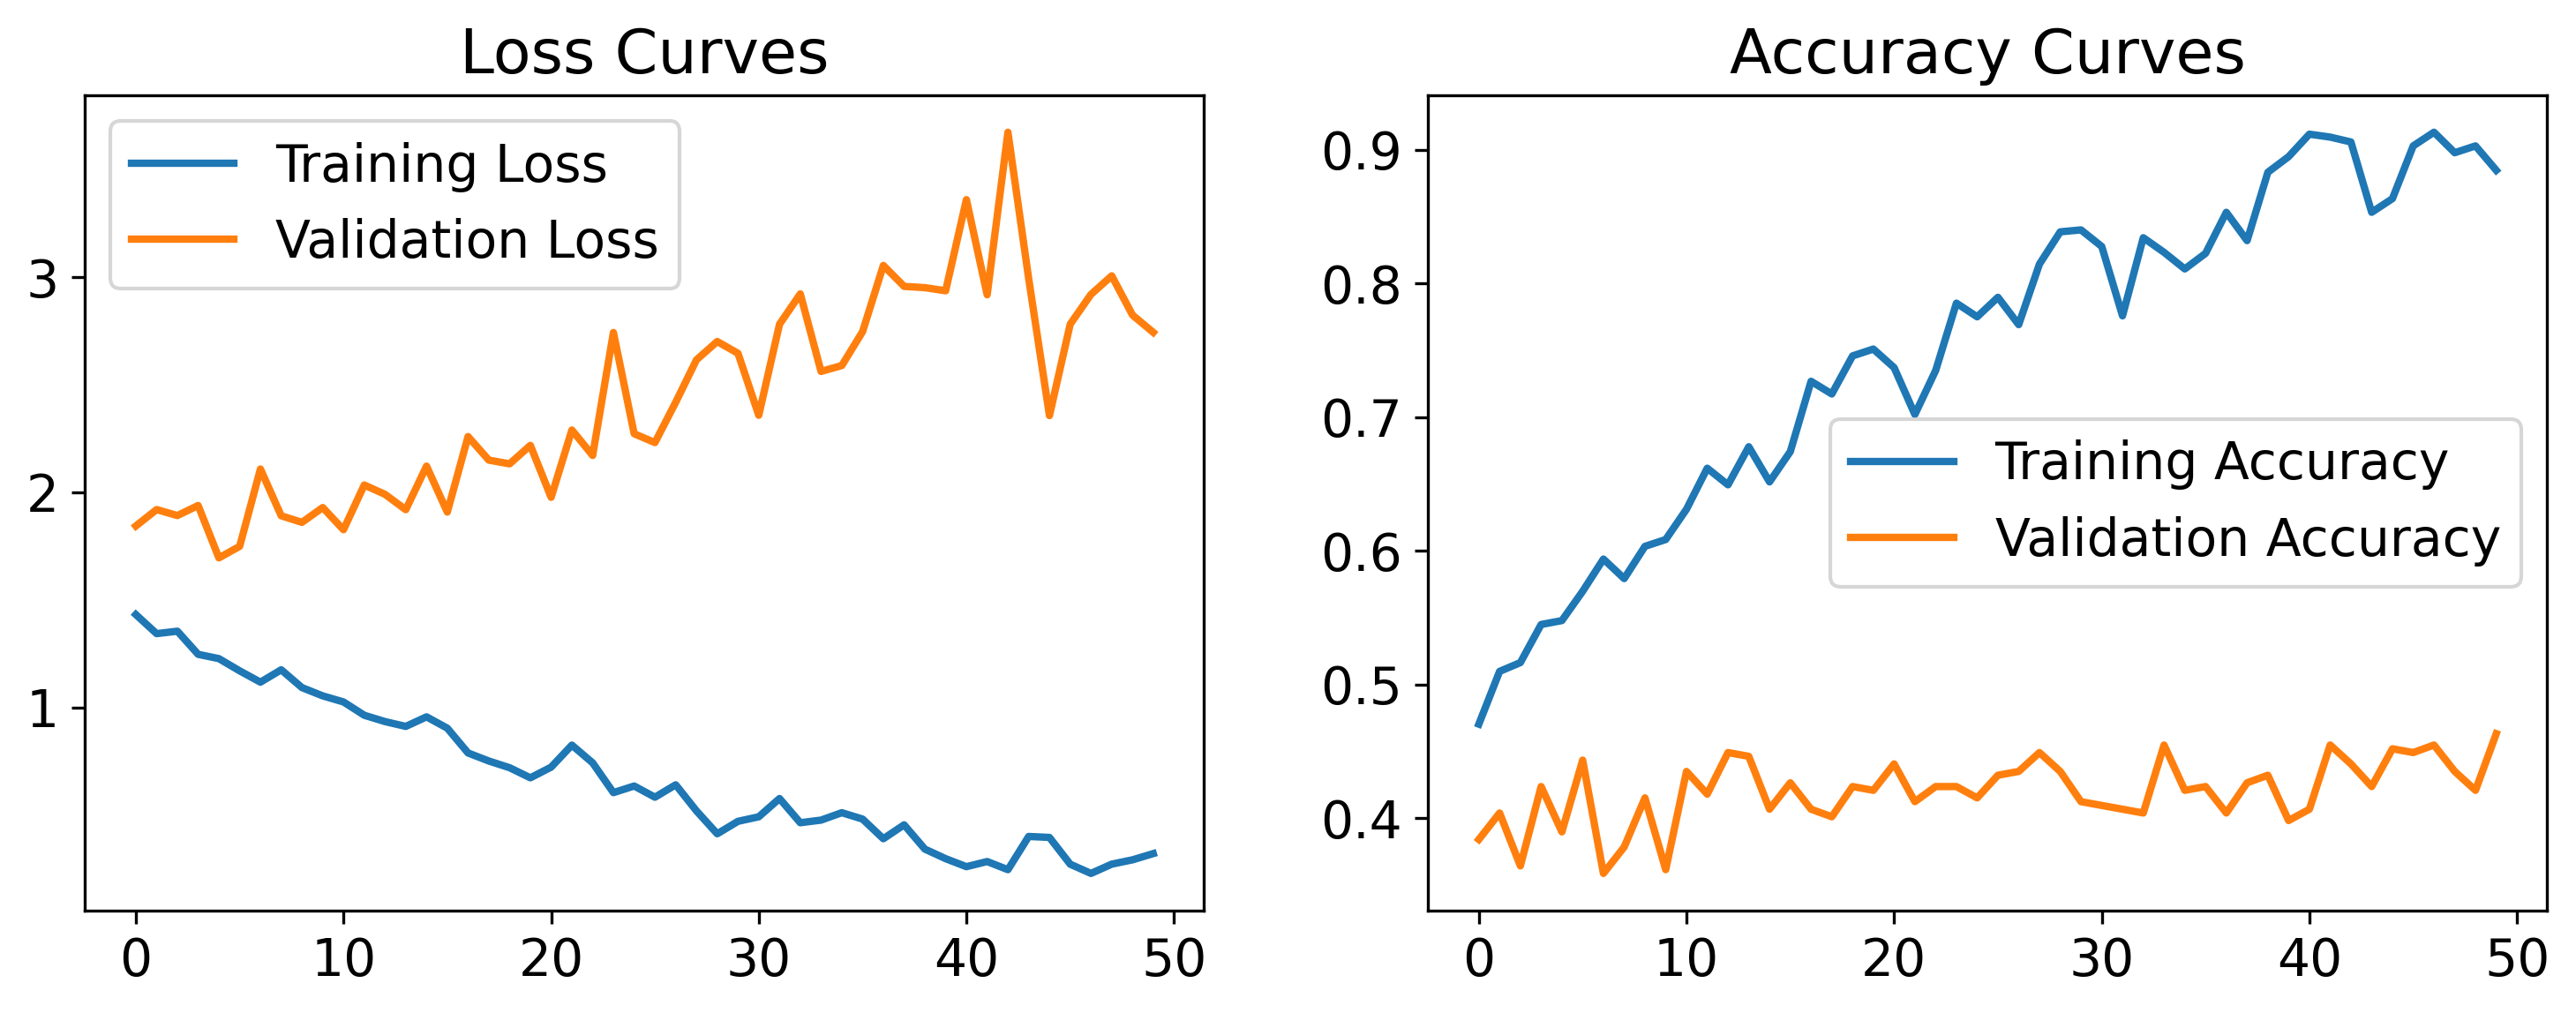

In [91]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
deit_model = deit_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deit_model.parameters())

dataloaders = {'train': train_loader_deit, 'val': val_loader_deit}

deit_model, train_acc, val_acc, train_loss, val_loss = train_deit_model(deit_model, dataloaders, criterion, optimizer, num_epochs=50)

#deit_model, train_acc, val_acc, train_loss, val_loss = train_deit_model(deit_model, {'train': train_loader_deit, 'val': val_loader_deit}, criterion, optimizer, num_epochs=25)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()


In [ ]:

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Load pre-trained DeiT model and adjust the classifier for your number of classes
# deit_model = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
# num_classes = len(classes) # classes is your list of classes
# deit_model.classifier = torch.nn.Linear(in_features=model.classifier.in_features, out_features=num_classes)
# deit_model.to(device)

# # Define your loss function and optimizer
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(deit_model.parameters(), lr=0.001)

# num_epochs = 20

# # Start training
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for i, data in enumerate(train_loader_deit, 0):
#         inputs, labels = data[0].to(device), data[1].to(device)
        
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = deit_model(inputs)
#         loss = criterion(outputs.logits, labels)
#         loss.backward()
#         optimizer.step()

#         # Print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0


#Evaluating the best model on the test dataset


[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 17 18]
[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.93      0.84      0.88        61
           6       0.85      1.00      0.92        17
           7       0.95      0.95      0.95        22
           8       0.93      1.00      0.97        43
           9       1.00      0.93      0.96        42
          11       1.00      1.00      1.00        29
          12       0.50      0.10      0.17        10
          13       0.00      0.00      0.00         3
          14       0.96      0.96      0.96        23
          16       0.56      0.82      0.67        22
          17       0.95      0.95      0.95        21
          18       1.00      0.96      0.98        28
          19       0.96      1.00      0.98        23
          23       0.60      0.75      0.67        20
          25       0.96   

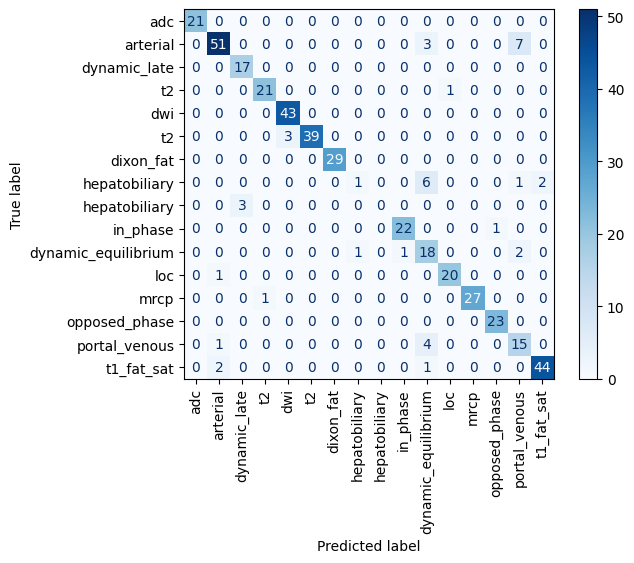

<Figure size 2500x2500 with 0 Axes>

In [35]:
# Create an instance of the model class
loaded_model = CustomDenseNet()


# Load the saved model
state_dict = torch.load('/content/gdrive/MyDrive/best_0606.pth')


# Load the state dictionary into the model
loaded_model.load_state_dict(state_dict)


# Evaluate the model on the test dataset
model = loaded_model.to(device)

model.eval()
test_predictions = []
test_labels = []

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        test_predictions.append(predicted.cpu().numpy())
        test_labels.append(labels.cpu().numpy())
test_predictions = np.concatenate(test_predictions, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

#print(val_predictions)
#print(val_labels)
cm = display_and_save_results2(test_predictions, test_labels, classes, fn='DenseNetFL', saveflag=True)







In [36]:
test_df['predictions'] = [classes[x] for x in test_predictions]
incorrect_df = test_df.copy()
incorrect_df = incorrect_df[incorrect_df.predictions!=incorrect_df.label]
incorrect_df = incorrect_df.reset_index()
incorrect_df.to_pickle('/content/gdrive/MyDrive/incorrect_df0606.pkl')
test_df.to_pickle('/content/gdrive/MyDrive/test_with_preds0606.pkl')

In [51]:
plt.rcParams['figure.dpi'] = 300

In [37]:
class ImgDatasetForVis(Dataset):
    def __init__(self, df, transform=None):
        self.data_df = df
        self.datafileslist = df.fname
        self.labels = df.label
        self.transform = transform
    
    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self, idx):
        img_file = self.data_df.fname[idx]
        ds = pydicom.dcmread(img_file)
        img = np.array(ds.pixel_array, dtype=np.float32)
        img = img[np.newaxis]
        img = torch.from_numpy(np.asarray(img))
        if self.transform: 
          img = self.transform(img)
        
        
        labl = self.data_df.label[idx]
        adjusted_label = classes.index(labl)
        y = torch.tensor(adjusted_label, dtype=torch.long)
        
        return img, y, img_file  # also return file path


# Create a data loader for visualization
vis_dataset = ImgDatasetForVis(test_df, data_transforms['test'])  
vis_loader = DataLoader(vis_dataset, batch_size=batch_size, shuffle=False)
incorrect_dataset= ImgDatasetForVis(incorrect_df, data_transforms['test'])
incorrect_loader = DataLoader(incorrect_dataset, batch_size=batch_size, shuffle=False)



In [54]:

def visualize_results2(model, dataloader, device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels, filenames = next(iter(dataloader))
        #print(filenames)
        #original_images = images.clone() # Store a copy of original images
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        labels = labels.cpu().numpy()
        

    center_crop = transforms.CenterCrop((256, 256))  # Adjust the crop size as needed
    resize = transforms.Resize((256, 256))  # Adjust the target size as needed
    
    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(20, 20))
    grid_size = 4
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(grid_size, grid_size, idx+1, xticks=[], yticks=[])
        #image = original_images[idx].mean(dim=0) # Average across the channel dimension
        #image = image.cpu().numpy()
        
        ds = pydicom.dcmread(filenames[idx])
        # Extract pixel array
        image = ds.pixel_array
        # Convert to PIL image
        #image = Image.fromarray(image).convert('L')

        # Apply center crop
        #image = resize(image)

        # Convert back to NumPy array
        #image = np.array(image)
        # Convert to float and normalize
        #image = np.array(image).astype('float32')
        #image /= 255.0

        image = image * 1.5  # Increase brightness by a factor of 1.5
       
        ax.imshow(image, cmap='gray')
        ax.set_title("{} ({})".format(abd_label_dict[str(classes[preds[idx]])]['short'], abd_label_dict[str(classes[labels[idx]])]['short']),
            color=("green" if preds[idx]==labels[idx] else "red"), fontsize=18)

    return

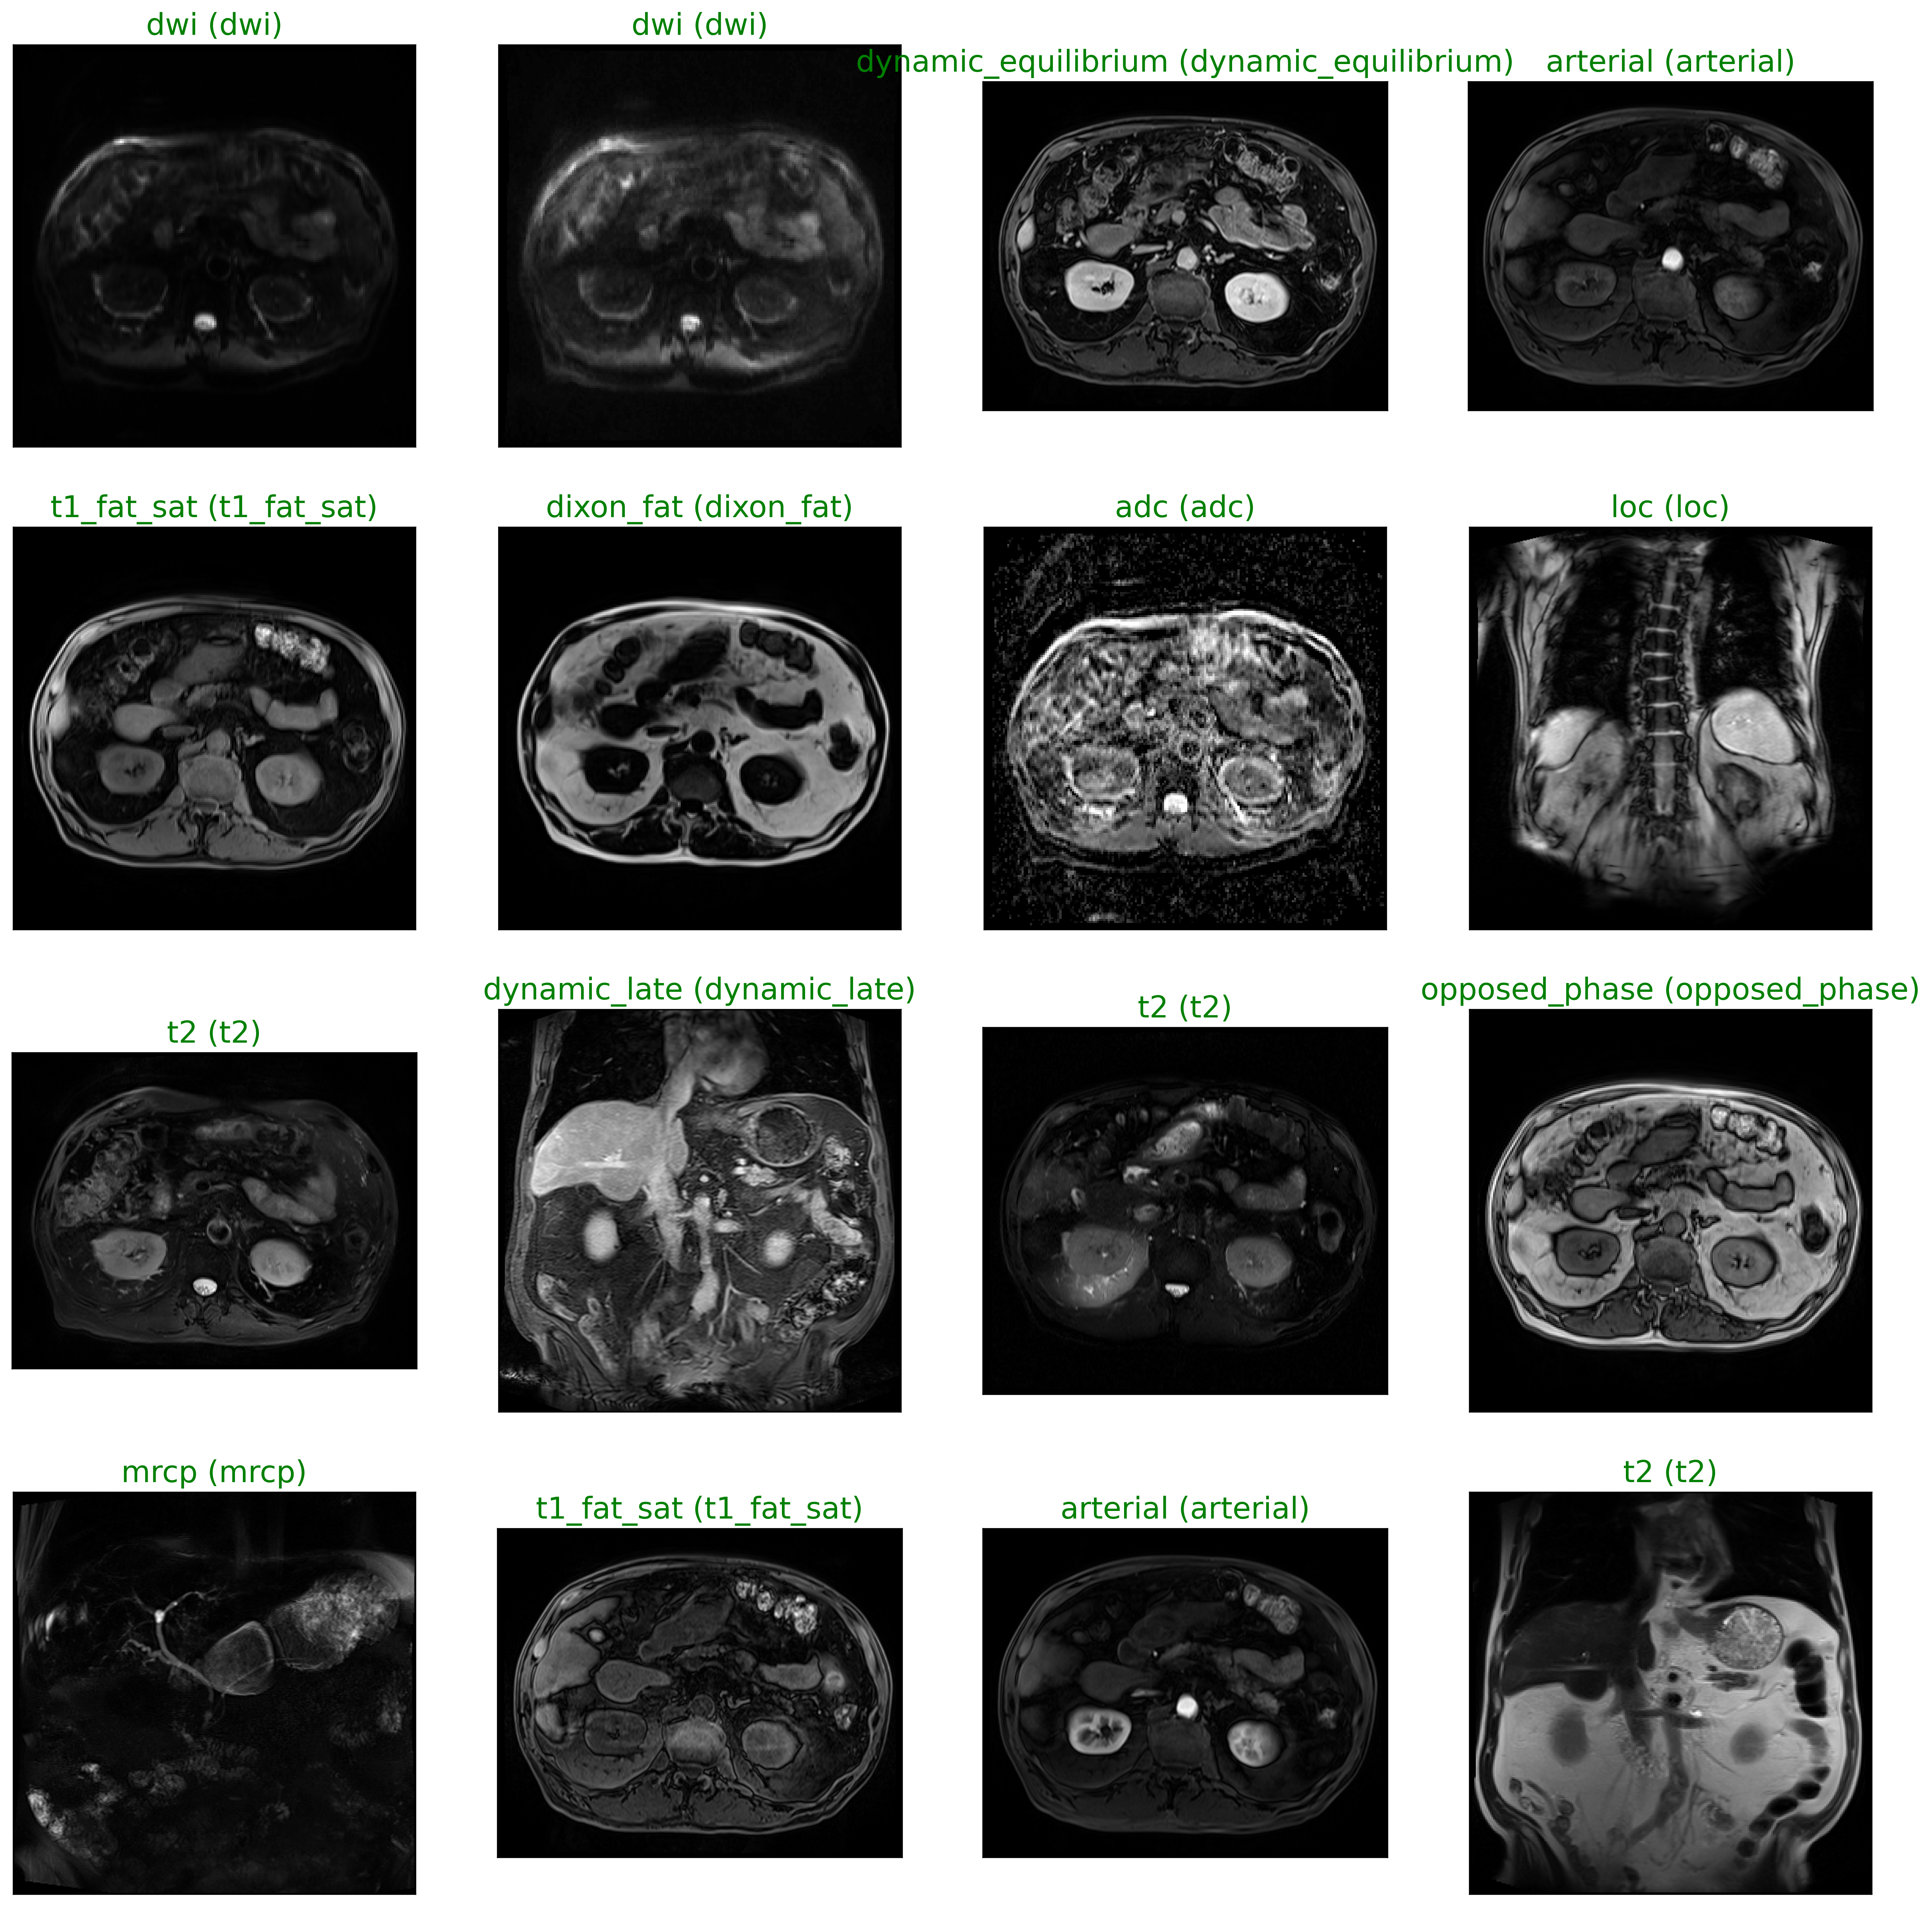

In [55]:
# Now use 'vis_loader' in your visualization function
visualize_results2(best_model, vis_loader, device)

In [66]:
## show incorrect predictions

def visualize_incorrect(df):
   
    # Get a batch of validation images
    filenames = df.fname
    preds = df.predictions 
    labels = df.label
        
        

    center_crop = transforms.CenterCrop((256, 256))  # Adjust the crop size as needed
    resize = transforms.Resize((256, 256))  # Adjust the target size as needed
    
    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(50, 50))
    grid_size = 4
    fontsize = 24

    for idx, row in df.iterrows():
        #print(idx)
        ax = fig.add_subplot(int(len(df)/grid_size)+1, grid_size, idx+1, xticks=[], yticks=[])
        filename = row['fname']
        pred = row['predictions']
        label = row['label']

       
        #ax = fig.add_subplot(grid_size, int(len(preds)/grid_size), idx+1, xticks=[], yticks=[])
        #image = original_images[idx].mean(dim=0) # Average across the channel dimension
        #image = image.cpu().numpy()
        
        ds = pydicom.dcmread(filenames[idx])
        # Extract pixel array
        image = ds.pixel_array
        # Convert to PIL image
        #image = Image.fromarray(image).convert('L')

        # Apply center crop
        #image = resize(image)

        # Convert back to NumPy array
        #image = np.array(image)
        # Convert to float and normalize
        #image = np.array(image).astype('float32')
        #image /= 255.0

        image = image * 1.5  # Increase brightness by a factor of 1.5
       
        ax.imshow(image, cmap='gray')
        ax.set_title("{} ({})".format(abd_label_dict[str(pred)]['short'], abd_label_dict[str(label)]['short']),
            color=("green" if pred==label else "red"), fontsize=18)

    return

In [81]:
def visualize_incorrect2(df):
    center_crop = transforms.CenterCrop((512, 512))  # Adjust the crop size as needed
    resize = transforms.Resize((512, 512))  # Adjust the target size as needed
    
    # Set plot parameters for publication quality
    plt.rcParams['figure.figsize'] = (8, 8)
    plt.rcParams['font.size'] = 14
    plt.rcParams['lines.linewidth'] = 2

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure()
    grid_size = 4

    for idx, row in df.iterrows():
        ax = fig.add_subplot(int(len(df)/grid_size)+1, grid_size, idx+1, xticks=[], yticks=[])
        filename = row['fname']
        pred = row['predictions']
        label = row['label']

        ds = pydicom.dcmread(filename)
        image = ds.pixel_array

        # Apply center crop
        #image = center_crop(image)

        # Increase brightness
        image = image * 1.5

        ax.imshow(image, cmap='gray')
        ax.set_title("{}\n({})".format(abd_label_dict[str(pred)]['short'], abd_label_dict[str(label)]['short']),
                     color=("green" if pred==label else "red"), fontsize=12)

        # Remove the axis labels
        ax.axis('off')

    plt.tight_layout()  # Adjust subplot parameters to give specified padding

    # Save the plot as a high-resolution image
    plt.savefig('publication-quality-plot_incorrect.png', dpi=300)

    plt.show()


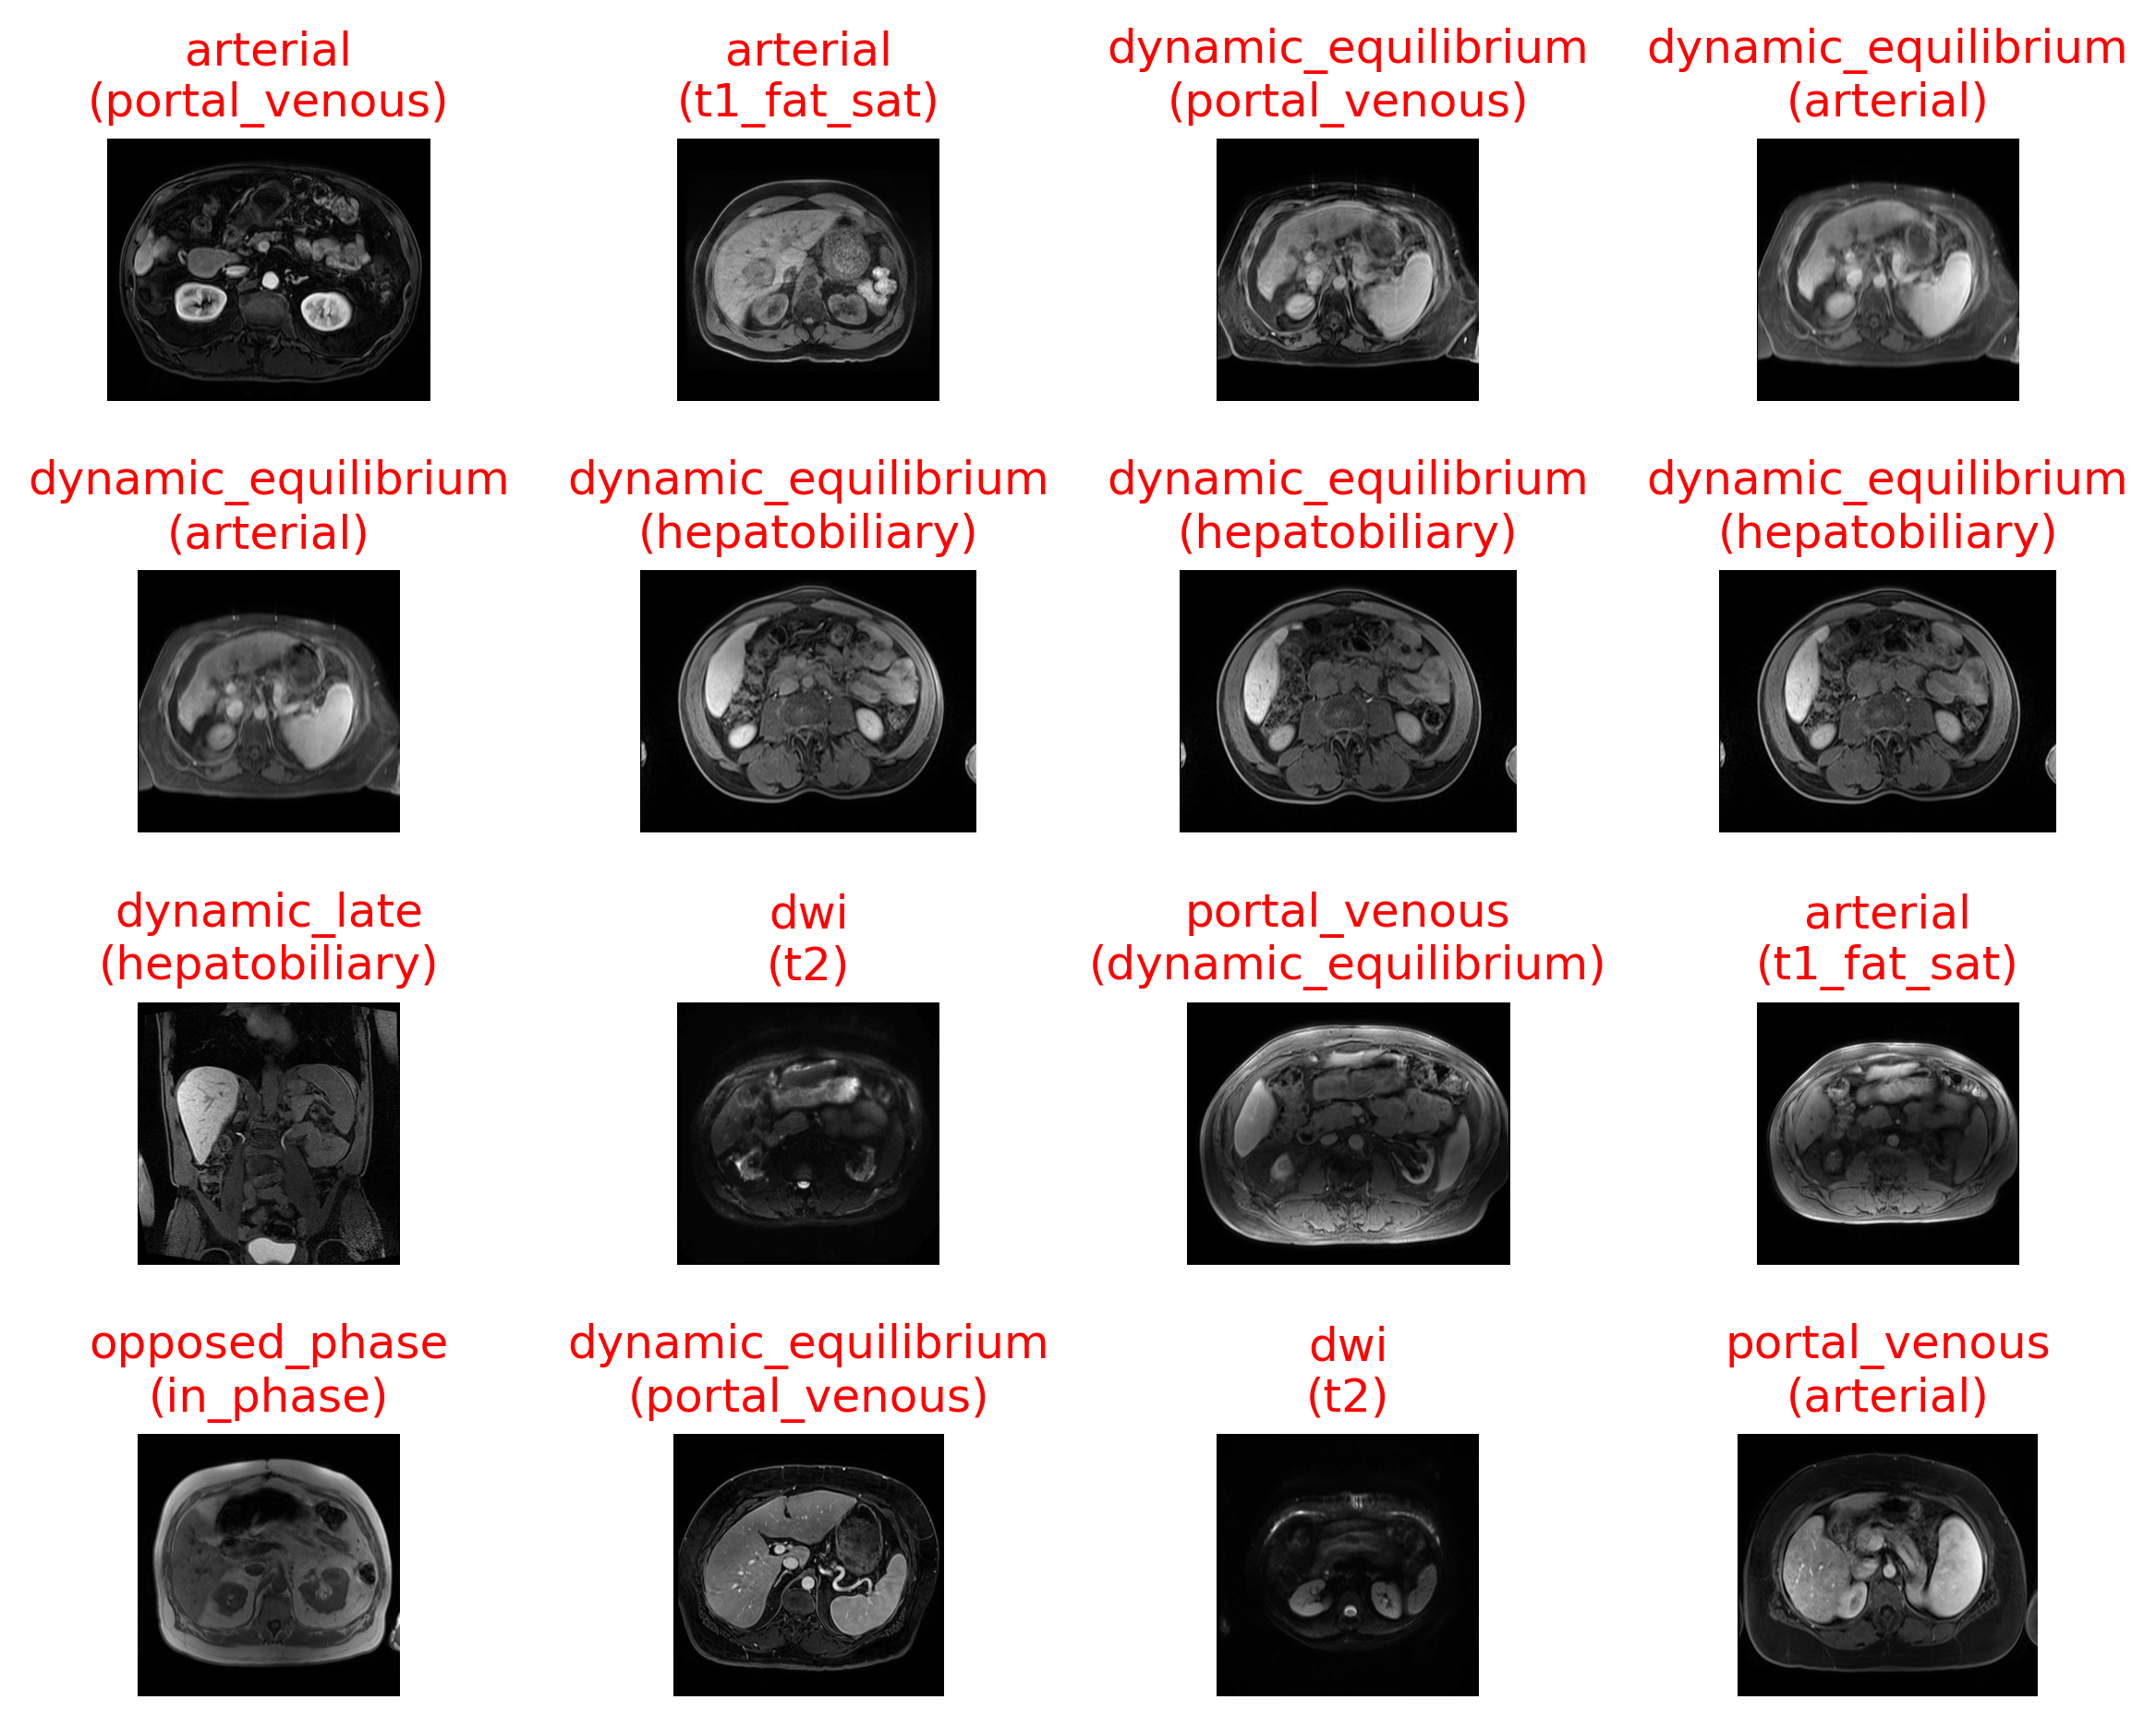

In [82]:
visualize_incorrect2(incorrect_df[:16])

In [ ]:
import torch
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt

def visualize_grad_cam(model, image, target_class):
    model.eval()
    image = image.unsqueeze(0)  # Add batch dimension
    image.requires_grad = True

    # Forward pass
    output = model(image)
    _, predicted_class = torch.max(output, 1)

    # Compute gradients
    model.zero_grad()
    one_hot_output = torch.zeros_like(output)
    one_hot_output[0, target_class] = 1
    output.backward(gradient=one_hot_output)

    # Get the gradients of the last convolutional layer
    gradients = model.get_activations_gradient()

    # Pool the gradients across channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Get the activations of the last convolutional layer
    activations = model.get_activations(image).detach()

    # Weight the activations by the gradients
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Average the weighted activations along the channels dimension
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)

    # Normalize the heatmap
    heatmap /= torch.max(heatmap)

    # Resize the heatmap to match the image size
    heatmap = F.interpolate(heatmap.unsqueeze(0).unsqueeze(0), size=(image.size(2), image.size(3)), mode="bilinear", align_corners=False)
    heatmap = heatmap.squeeze().numpy()

    # Plot the heatmap and the original image
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image.squeeze().permute(1, 2, 0))
    ax1.axis('off')
    ax1.set_title('Original Image')
    ax2.imshow(image.squeeze().permute(1, 2, 0))
    ax2.imshow(heatmap, alpha=0.5, cmap='jet')
    ax2.axis('off')
    ax2.set_title('Grad-CAM Heatmap')
    plt.tight_layout()
    plt.show()

# Usage:
model = YourModel()  # Replace with your own model
image = ...  # Load or generate the input image
target_class = 0  # Specify the target class for visualization
visualize_grad_cam(model, image, target_class)
